# **Neural steering controller for autonomous parking**

This tutorial implements the physics-driven neural steering controller of the paper titled:

*Fast Planning and Tracking of Complex Autonomous Parking Maneuvers With Optimal Control and Pseudo-Neural Networks*

(available at https://ieeexplore.ieee.org/abstract/document/10309845)

## Initialization

### Import packages

In [ ]:
import sys, os
print('Current working directory: ',os.getcwd())
sys.path.append(os.path.join(os.getcwd(),'..'))

import torch
import pandas as pd
import scipy as sp
import numpy as np

from nnodely.support.utils import *
from nnodely import *
from nnodely.support import earlystopping

# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

# enable zooming on the plots
%matplotlib inline
import mpld3
mpld3.enable_notebook()


Current working directory:  /Users/giovanni/Desktop/Projects/nnodely-applications/vehicle/control_steer_car_parking


### Configurations, known constant parameters and initial guesses

In [7]:
# Path to the data folder
data_folder = os.path.join(os.getcwd(),'dataset')
# Import the file with the vehicle data
vehicle_data_csv = os.path.join(data_folder,'other_data','vehicle_data.csv')

# Import the file with the steering maps
steer_maps_file = os.path.join(data_folder,'other_data','steer_map.txt')
steer_map_load  = np.loadtxt(steer_maps_file, delimiter='\t', skiprows=1)
delta_w_avg_map_values = np.float64(np.deg2rad(steer_map_load[:,0]))
delta_w_avg_map_values = delta_w_avg_map_values[:,np.newaxis].tolist()  # add a dimension
delta_sw_map_values = np.float64(np.deg2rad(steer_map_load[:,1]))
delta_sw_map_values = delta_sw_map_values[:,np.newaxis].tolist()  # add a dimension

# Initial guesses
# Load the initial guesses for the curvature diagram approximation, computed in Matlab with a 2nd order optimizer
initial_guesses_curv_diagr = sp.io.loadmat(os.path.join(data_folder,'other_data','initial_guesses_curv_diagram','fit_curv_diagr_5th_ord_poly.mat'))
curv_diagram_params_guess = initial_guesses_curv_diagr['optim_params_poly'][0].astype('float64')

## NN model

### Custom parametric functions

In [8]:
# -------------------------------------------------
# Curvature diagram
# -------------------------------------------------
def curvat_diagram(curv,L,h_1,h_2,h_3):
  return torch.atan(h_1*curv + h_2*torch.pow(curv,3) + h_3*torch.pow(curv,5) + curv*L)

### Internal architecture

In [ ]:
# -------------------------------------------------
# Neural model inputs and outputs
# -------------------------------------------------
curv         = Input('curv')          # [1/m] path curvature
steer        = Input('steer')         # [rad] steering wheel angle 
steer_target = Input('steer_target')  # [rad] steering wheel angle --> this is used only as a training target

num_samples_future_curv = 15   # number of samples in the future for the curvature prediction
num_samples_past_steer  = 15   # number of samples in the past for the steering wheel angle prediction

# Non-trainable parameters:
# Vehicle data
L = Constant('L',values=pd.read_csv(vehicle_data_csv)['L'][0].item())  # [m] wheelbase

# Trainable parameters:
# Curvature diagram parameters
h_1_guess = Parameter('h_1',values=[[curv_diagram_params_guess[0].item()]])  # initial guess
h_2_guess = Parameter('h_2',values=[[curv_diagram_params_guess[1].item()]])  # initial guess
h_3_guess = Parameter('h_3',values=[[curv_diagram_params_guess[2].item()]])  # initial guess

# Parametric function to learn the curvature diagram 
out_curv_diagr = ParamFun(curvat_diagram, parameters_and_constants=[L,h_1_guess,h_2_guess,h_3_guess])(curv.sw([0,num_samples_future_curv]))

# FIR layer to weigh the future predictions of the curvature diagram
out_fir = Fir(W='fir_future_curv', W_init='init_exp', W_init_params={'size_index':0, 'max_value':0.1, 'lambda':5, 'monotonicity':'decreasing'})(out_curv_diagr)

# Parametric function to model the steering map (i.e., the relation between the average steering angle at the front wheels and the steering wheel angle)
delta_w_avg_map = Constant('delta_w_avg_map',values=delta_w_avg_map_values)  # [rad] average steering angle at the front wheels
delta_sw_map    = Constant('delta_sw_map',values=delta_sw_map_values)        # [rad] steering wheel angle
#out_steer_map   = ParamFun(linear_interp, parameters_and_constants=[delta_w_avg_map,delta_sw_map], map_over_batch=False)(out_fir)    # map_over_batch=True is used to apply the function to each sample in the batch
out_steer_map = Interpolation(x_points=[x[0] for x in delta_w_avg_map_values],y_points=[y[0] for y in delta_sw_map_values])(out_fir)

# FIR layer to weigh the past steering wheel angles computed by the NN (auto-regressive model)
out_arx = Fir(W='fir_auto_regression', W_init='init_exp', W_init_params={'size_index':0, 'max_value':1e-3, 'lambda':5, 'monotonicity':'increasing'})(steer.sw([-num_samples_past_steer,0]))

# Output of the neural model
out = Output('steering_angle', out_steer_map + out_arx)

[check_names] The name 'curv' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'steer' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'steer_target' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'L' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'h_1' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'h_2' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'h_3' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'fir_future_curv' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'delta_w_avg_map' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'delta_sw_map' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'fir_auto_regression' is already in defined as NeuObj but it is overwritten.
[check_names] The

### nnodely framework

In [22]:
# Create a nnodely model
path_folder_save      = os.path.join(os.getcwd(),'trained_models')    # folder to save the model
steer_controller_park = nnodely(visualizer='Standard',seed=12,workspace=path_folder_save,save_history=False)  #visualizer=MPLVisulizer()

# Add the neural model to the nnodely structure and neuralization of the model
steer_controller_park.addModel('steer_ctrl',[out])
steer_controller_park.addMinimize('steer_error', 
                                  steer_target.next(),  # next means the first value in the "future"
                                  out, 
                                  loss_function='mse')
steer_controller_park.neuralizeModel()

================================ nnodely Model =================================
{'Constants': {'L': {'dim': 1, 'values': [2.5999999046325684]}},
 'Functions': {'FParamFun155': {'code': 'def '
                                        'curvat_diagram(curv,L,h_1,h_2,h_3):\n'
                                        '  return torch.atan(h_1*curv + '
                                        'h_2*torch.pow(curv,3) + '
                                        'h_3*torch.pow(curv,5) + curv*L)\n',
                                'in_dim': [{'dim': 1, 'sw': 15}],
                                'map_over_dim': False,
                                'n_input': 1,
                                'name': 'curvat_diagram',
                                'params_and_consts': ['L',
                                                      'h_1',
                                                      'h_2',
                                                      'h_3']}},
 'Info': {'SampleTime': 1,
          'n

## Training and validation datasets

In [23]:
# Load the training and the validation dataset
data_struct = ['curv',('steer','steer_target')]  # both steer and steer_target are read from the same column of the csv file
data_folder_train = os.path.join(data_folder,'training')
data_folder_valid = os.path.join(data_folder,'validation')
data_folder_test  = os.path.join(data_folder,'test')
steer_controller_park.loadData(name='training_set', source=data_folder_train, format=data_struct, skiplines=1)
steer_controller_park.loadData(name='validation_set', source=data_folder_valid, format=data_struct, skiplines=1)
steer_controller_park.loadData(name='test_set', source=data_folder_test, format=data_struct, skiplines=1)

# check the definition of the windows in the inputs and outputs
#samples_test_set = steer_controller_park.get_samples('training_set', index=100, window=1) 
#print(samples_test_set)

============================ nnodely Model Dataset =============================
Dataset Name:                 training_set
Number of files:              1
Total number of samples:      3092
Shape of steer:               (3092, 15, 1)
Shape of curv:                (3092, 15, 1)
Shape of steer_target:        (3092, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 validation_set
Number of files:              1
Total number of samples:      832
Shape of steer:               (832, 15, 1)
Shape of curv:                (832, 15, 1)
Shape of steer_target:        (832, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 test_set
Number of files:              1
Total number of samples:      691
Shape of steer:               (691, 15, 1)
Shape of curv:                (691, 15, 1)
Shape of steer_target:        (691, 1, 1)


## Training

### Train the NN in open-loop (no auto-regressive term)

In [24]:
num_epochs = 6000
batch_size = 100
learn_rate = 1e-3  # learning rate
early_stop_patience = 100
training_pars_open_loop = {'num_of_epochs':num_epochs, 
                           'val_batch_size':batch_size, 
                           'train_batch_size':batch_size, 
                           'lr':learn_rate}

train_result_open_loop = steer_controller_park.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
                                                          training_params=training_pars_open_loop, optimizer='Adam', shuffle_data=True,
                                                          early_stopping=earlystopping.early_stop_patience,  
                                                          early_stopping_params={'patience':early_stop_patience,
                                                                                 'error':'steer_error'},
                                                          select_model=earlystopping.select_best_model)  

======================== nnodely Model Train Parameters ========================
models:                       ['steer_ctrl']
num of epochs:                6000
update per epochs:            30
└>(n_samples-batch_size)/batch_size+1
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'steer_error', 'patience': 100}
train dataset:                training_set
	- batch size:                100
	- num of samples:            3092
validation dataset:           validation_set
	- batch size:                100
	- num of samples:            832
minimizers:                   {'steer_error': {'A': 'SamplePart62',
                                               'B': 'Add60',
                                               'loss': 'mse'}}
optimizer:                    Adam
optimizer defaults:           {'lr': 0.001}
optimizer params:             [{'params': 'fir_auto_regression'},
                               {'params': 'fir_fu

In [25]:
# Save the trained model
steer_controller_park.saveModel()

# Load the trained model
# steer_controller_park.loadModel() 

=============================== Save JSON Model ================================
Model saved in:               /Users/giovanni/Desktop/Projects/nnodely-applications/vehicle/control_steer_car_parking/trained_models/net.json


### Re-train the NN in auto-regressive mode (closed-loop training)

In [26]:
num_epochs = 1000
batch_size = 50
learn_rate = 1e-3  # learning rate
early_stop_patience = 50
training_pars_closed_loop = {'num_of_epochs':num_epochs, 
                             'val_batch_size':batch_size, 
                             'train_batch_size':batch_size, 
                             'lr':learn_rate}

predict_samples = 50  # number of samples after which the internal state is reset
steps_skip = 1  # number of samples to skip when going to a new window. The default is 1, meaning the size of a batch. If steps_skip = predict_samples, then the whole window size is skipped

# NOTE: by default, the next batch skips a full length of a batch
# NOTE: shuffle = True shuffles only the order of the batches, so it's ok with the autoregression

train_result_closed_loop = steer_controller_park.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
                                                            training_params=training_pars_closed_loop, optimizer='Adam', shuffle_data=False,
                                                            early_stopping=earlystopping.early_stop_patience, 
                                                            early_stopping_params={'patience':early_stop_patience,
                                                                                   'error':'steer_error'},
                                                            prediction_samples=predict_samples, step=steps_skip, 
                                                            closed_loop={'steer':'steering_angle'},
                                                            select_model=earlystopping.select_best_model)  

======================== nnodely Model Train Parameters ========================
models:                       ['steer_ctrl']
num of epochs:                1000
update per epochs:            59
└>len(train_indexes)//(batch_size+step)
early stopping:               early_stop_patience
early stopping params:        {'error': 'steer_error', 'patience': 50}
prediction samples:           50
step:                         1
closed loop:                  {'steer': 'steering_angle'}
connect:                      {}
train dataset:                training_set
	- batch size:                50
	- num of samples:            3092
	- num of first samples:      3042
validation dataset:           validation_set
	- batch size:                50
	- num of samples:            832
	- num of first samples:      782
minimizers:                   {'steer_error': {'A': 'SamplePart62',
                                               'B': 'Add60',
                                               'loss': 'mse'}}
optim

### Print the parameters of the trained NN

In [27]:
# Save the trained model
steer_controller_park.saveModel('recurrent_net')

# Load the trained model
# steer_controller_park.loadModel('recurrent_net')

=============================== Save JSON Model ================================
Model saved in:               /Users/giovanni/Desktop/Projects/nnodely-applications/vehicle/control_steer_car_parking/trained_models/recurrent_net.json


## Test on a new dataset

MSE on the test set:  [0.00024249]  rad^2


/Users/giovanni/Desktop/Projects/nnodely-applications/.venv/lib/python3.12/site-packages/mpld3/mplexporter/utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
/Users/giovanni/Desktop/Projects/nnodely-applications/.venv/lib/python3.12/site-packages/mpld3/mplexporter/utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
/Users/giovanni/Desktop/Projects/nnodely-applications/.venv/lib/python3.12/site-packages/mpld3/mplexporter/utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods ins

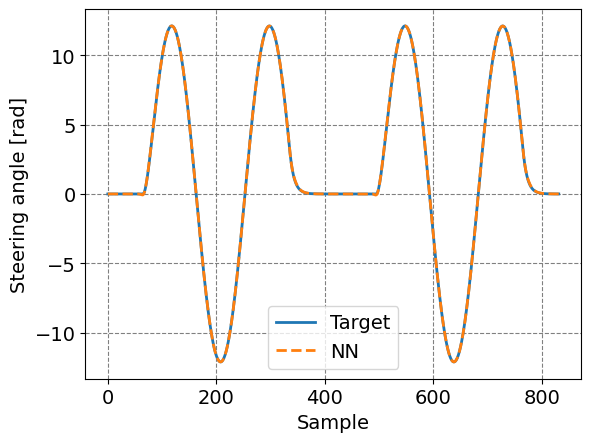

In [28]:
# Test on a new dataset
num_samples_use  = 832
samples_test_set = steer_controller_park.getSamples('validation_set', index=0, window=num_samples_use) 
steer_controller_park.resetStates()  # reset the internal state
out_nn_test_set         = steer_controller_park(samples_test_set, sampled=True,
                                                prediction_samples=num_samples_use,
                                                closed_loop={'steer':'steering_angle'}
                                                )
out_nn_test_set_extract = out_nn_test_set['steering_angle']

# extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['steer_target']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['steer_target'][i]

# Compute the MSE on the test set
mse_calc = 0
for i in range(0,len(samples_test_set_extract)):
  mse_calc = mse_calc + (samples_test_set_extract[i] - out_nn_test_set_extract[i])**2 
mse_calc = mse_calc/len(samples_test_set_extract)
print('MSE on the test set: ', mse_calc, ' rad^2')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot(samples_test_set_extract,label='Target',linewidth=2)
  plt.plot(out_nn_test_set_extract,label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Steering angle [rad]')
  plt.legend()
  plt.grid()
  plt.show()

# Test with custom data
#steer_controller_park({'curv':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],'steer':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]})